In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

In [2]:
words = open("../../makemore/names.txt", "r").read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)

print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
block_size = 3
def build_dataset(words):  

  X, Y = [], []
  
  for w in words:

    context = [0] * block_size
    for ch in w + '.':

      ix = stoi[ch]

      X.append(context)
      Y.append(ix)

      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# E01: Zero Initialization
What will happen?
1) the network trains just fine
2) the network doesn't train at all, but actually it is 
3) the network trains but only partially, and achieves a pretty bad final performance. 

Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

In [5]:
gain = 0.2
last_layer_confidence = 0.1

using_batch_norm = False
div_by_fan_in = False

In [6]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.zeros((fan_in, fan_out))
        if div_by_fan_in:
            self.weight /= fan_in ** 0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained while running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # batch mean
            xmean = x.mean(0, keepdim= True)
            # batch variance
            xvar = x.var(0, keepdim= True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers in training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.zeros((vocab_size, n_embd))

if not using_batch_norm:
    layers = [
        Linear(n_embd * block_size, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, vocab_size)
    ]
if using_batch_norm:
    layers = [
    Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(         n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(         n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(         n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(         n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(         n_hidden, vocab_size, bias = False), BatchNorm1d(vocab_size) # you can add it here too
    ]



with torch.no_grad():
    # last layer: make less confident
    if not using_batch_norm:
        layers[-1].weight *= last_layer_confidence
    if using_batch_norm:
        layers[-1].gamma *= last_layer_confidence
    
    # other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # change this gain (default 5/3)
            layer.weight *= gain

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

NameError: name 'n_embd' is not defined

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
update_to_data_ratio = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed characters into vector space
    x = emb.view((emb.shape[0], -1)) # flatten
    for layer in layers:
        x = layer(x)
    # compute loss
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f"step {i} loss {loss.item()}")


    lossi.append(loss.item())

    # update to data ratio: How great is the update compared to the data itself?
    with torch.no_grad():
        update_to_data_ratio.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters if p.grad is not None])


step 0 loss 3.295837163925171
step 10000 loss 2.695582389831543
step 20000 loss 2.497403860092163
step 30000 loss 2.887847900390625
step 40000 loss 3.026440143585205
step 50000 loss 2.5869102478027344
step 60000 loss 2.85266375541687
step 70000 loss 2.759803056716919
step 80000 loss 2.946882963180542
step 90000 loss 2.623911142349243
step 100000 loss 2.7684364318847656


## weights Exploration

## Visualizations

layer 1 mean 0.00 std 0.00 saturated 0.00%
layer 3 mean 0.00 std 0.00 saturated 0.00%
layer 5 mean 0.00 std 0.00 saturated 0.00%
layer 7 mean 0.00 std 0.00 saturated 0.00%
layer 9 mean 0.00 std 0.00 saturated 0.00%


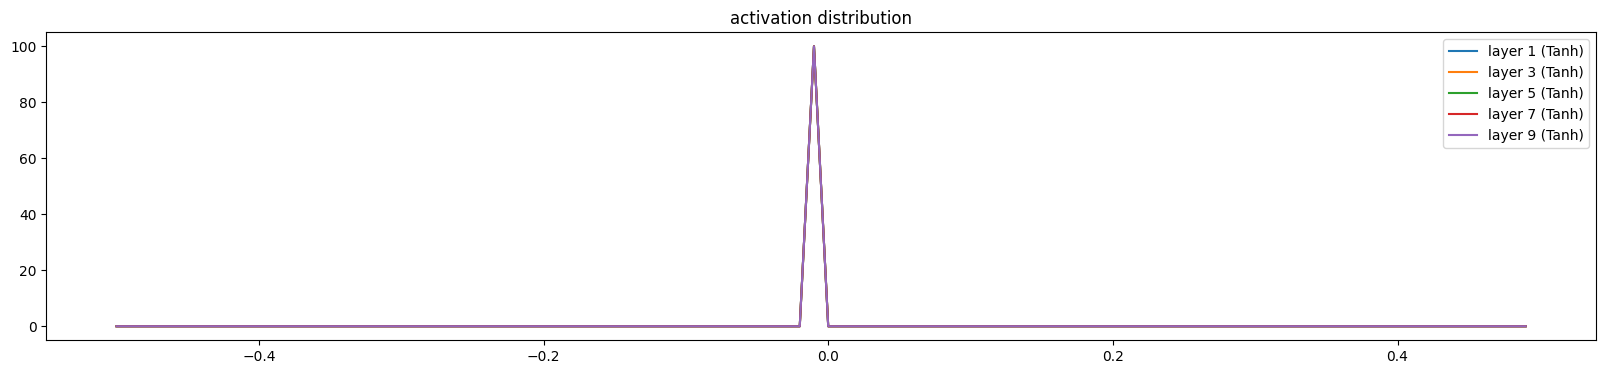

In [110]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"layer {i} mean {t.mean().item():.2f} std {t.std().item():.2f} saturated {((t.abs() > 0.97).float().mean().item()) * 100:.2f}%")

        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())

        legends.append(f"layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("activation distribution")
plt.show()

weight shape (27, 10) | mean 0.00000 | std 0.00000 | grad:data ratio nan
weight shape (30, 100) | mean 0.00000 | std 0.00000 | grad:data ratio nan
weight shape (100, 100) | mean 0.00000 | std 0.00000 | grad:data ratio nan
weight shape (100, 100) | mean 0.00000 | std 0.00000 | grad:data ratio nan
weight shape (100, 100) | mean 0.00000 | std 0.00000 | grad:data ratio nan
weight shape (100, 100) | mean 0.00000 | std 0.00000 | grad:data ratio nan
weight shape (100, 27) | mean 0.00000 | std 0.00000 | grad:data ratio nan
last layer weight shape (27,) | mean 0.00000 | std 0.02692 | grad:data ratio 2.27e-02


Text(0.5, 1.0, 'Weights Gradient distribution')

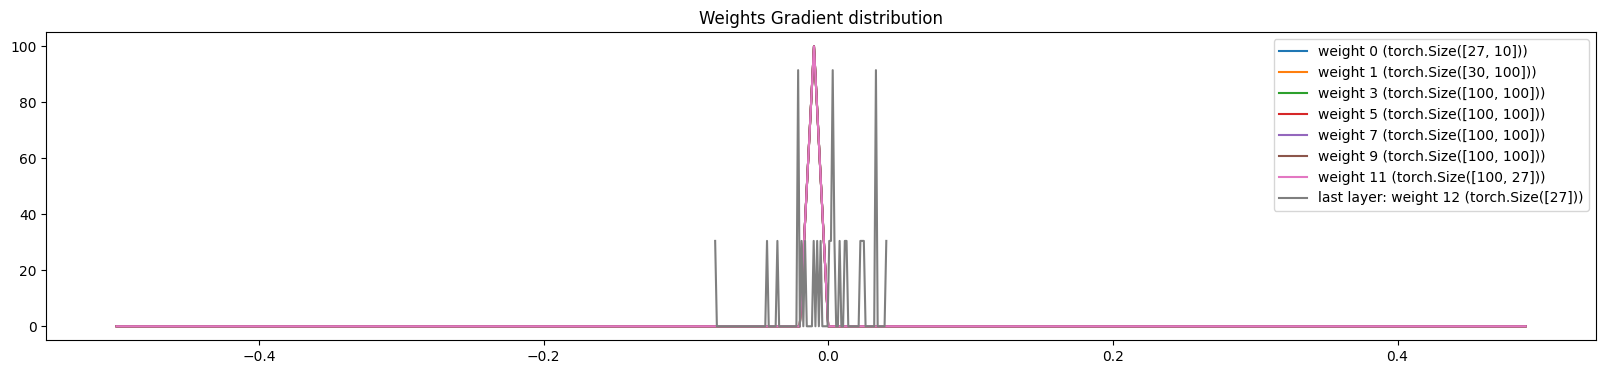

In [143]:
plt.figure(figsize=(20, 4))
legends = []

for i,p in enumerate(parameters):
    t = p.grad

    # neglect bias and batch norm parameters (weights only)
    if p.ndim == 2:
        print(f"weight shape {tuple(p.shape)} | mean {t.mean().item():.5f} | std {t.std().item():.5f} | grad:data ratio {t.std() / p.std():.2e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())

        legends.append(f"weight {i} ({p.shape})")
    if i == len(parameters) - 1:
        print(f"last layer weight shape {tuple(p.shape)} | mean {t.mean().item():.5f} | std {t.std().item():.5f} | grad:data ratio {t.std() / p.std():.2e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())

        legends.append(f"last layer: weight {i} ({p.shape})")
    

plt.legend(legends)
plt.title("Weights Gradient distribution")

Comment: The last layer's biases has learned, but the weights are still zero.

however, all other layers have zero weights and biases.

# E02: Folding Batchnorm Parameters to Linear Layer
- Set up and train a small 3-layer MLP with batchnorms, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b
by creating a new W2, b2 and erasing the batch norm. 
- Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

## Explaination (From Bing Chat with modifcations)
BatchNorm is a technique that normalizes the input of each layer to make the training process faster and more stable.
It consists of two steps:

    1- normalizing the batch by subtracting its mean and dividing it by its standard deviation.
    2- scaling and shifting it by two learnable parameters called gamma and beta.

However, at inference time, BatchNorm is **not necessary** and can be removed to speed up the network.

One way to remove BatchNorm is to fold it into the preceding linear layer, which is also a `linear transformation`.

This means that we can combine the `weights` and `biases` of the **linear** **layer** with the `gamma` and `beta` of the **BatchNorm layer** to get a new linear layer that has the same output as the original one.

This can be done by rearranging the terms of the linear transformation as follows:

$$
y = \text{Linear}(x) = Wx + b
$$

$$
z = \text{BatchNorm}(y) = \gamma \frac{y - \mu}{\sigma} + \beta
$$

$$
z = \text{BatchNorm}(\text{Linear}(x)) = \gamma \frac{Wx + b - \mu}{\sigma} + \beta
$$

$$
z = (\frac{\gamma}{\sigma})Wx + (\frac{\gamma}{\sigma})(b - \mu) + \beta
$$

$$
z = W_2 x + b_2
$$

where $$W_2 = (\frac{\gamma}{\sigma})W$$ and $$b_2 = (\frac{\gamma}{\sigma})(b - \mu) + \beta$$


## Init The Model

In [101]:
# visualization parameters (play with these)
gain = 3/5
last_layer_confidence = 0.1

using_batch_norm = True
div_by_fan_in = True

In [102]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g)
        if div_by_fan_in:
            self.weight /= fan_in ** 0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained while running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # batch mean
            xmean = x.mean(0, keepdim= True)
            # batch variance
            xvar = x.var(0, keepdim= True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers in training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),       generator = g)

if not using_batch_norm:
    layers = [
        Linear(n_embd * block_size, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, vocab_size)
    ]
if using_batch_norm:
    layers = [
    Linear(n_embd * block_size, n_hidden, bias = True), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(         n_hidden, n_hidden, bias = True), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(         n_hidden, vocab_size, bias = True), BatchNorm1d(vocab_size) # you can add it here too
    ]

with torch.no_grad():
    # last layer: make less confident
    if not using_batch_norm:
        layers[-1].weight *= last_layer_confidence
    if using_batch_norm:
        layers[-1].gamma *= last_layer_confidence
    
    # other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # change this gain (default 5/3)
            layer.weight *= gain

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

16651


## Training

In [103]:
# same optimization as last time
# set it training mode
max_steps = 200000
batch_size = 32
lossi = []
update_to_data_ratio = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed characters into vector space
    x = emb.view((emb.shape[0], -1)) # flatten
    for layer in layers:
        x = layer(x)
    # compute loss
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f"step {i} loss {loss.item()}")
    
    if i == 10000:
        break

    lossi.append(loss.item())

    # update to data ratio: How great is the update compared to the data itself?
    with torch.no_grad():
        update_to_data_ratio.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters if p.grad is not None])

step 0 loss 3.3137688636779785
step 10000 loss 2.7345333099365234


## Testing (With BatchNorm):

In [195]:
# forward pass
emb = C[Xte] # embed characters into vector space
x = emb.view((emb.shape[0], -1)) # flatten
for layer in layers:
    layer.training = False
    x = layer(x)

# compute loss
loss = F.cross_entropy(x, Yte)
print(f"test loss {loss.item()}")

test loss 2.233304262161255


## Testing (Folded BatchNorm to Previous Linear Layer):

In [196]:
emb = C[Xte] # embed zharacters into vector space
x = emb.view((emb.shape[0], -1)) # flatten

for layeridx in range(len(layers)):
    # forward pass through Linear layers only (Neglect batch norm)
    if isinstance(layers[layeridx], Linear):
        # fold the batch norm into the weights
        l = Linear(layers[layeridx].weight.shape[0], layers[layeridx].weight.shape[1], bias = True)
        
        l.weight = layers[layeridx].weight * (layers[layeridx + 1].gamma / torch.sqrt(layers[layeridx + 1].running_var + layers[layeridx + 1].eps))
        if layers[layeridx].bias is not None:
            l.bias = (layers[layeridx].bias - layers[layeridx + 1].running_mean) * (layers[layeridx + 1].gamma / torch.sqrt(layers[layeridx + 1].running_var + layers[layeridx + 1].eps)) + layers[layeridx + 1].beta
            
        x = l(x)
    if isinstance(layers[layeridx], Tanh):
        x = layers[layeridx](x)

# compute loss
loss = F.cross_entropy(x, Yte)
print(f"test loss {loss.item()}")

test loss 2.233304500579834
